In [1]:
from efficientnet_pytorch import EfficientNet

import torch
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.special import softmax
import cv2
from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW
from tqdm import tqdm
from albumentations import *
from albumentations.pytorch import ToTensor
import gc

import warnings
warnings.filterwarnings("ignore")
import pretrainedmodels as models

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/home/renat/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Text(0.5, 1.0, 'Scab')

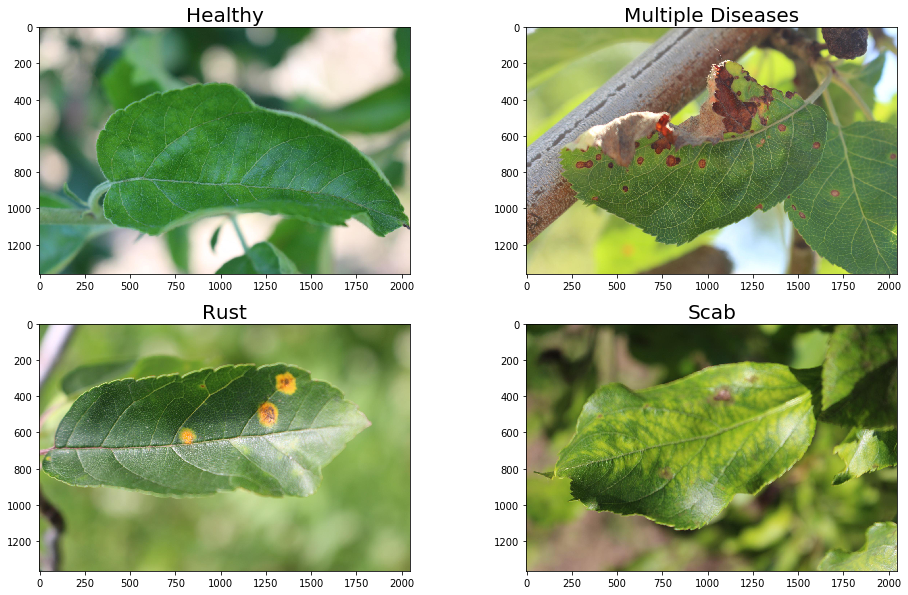

In [2]:
im_healthy = plt.imread('images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread('images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread('images/Train_0.jpg', format = 'jpg')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title('Healthy', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title('Multiple Diseases', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title('Rust', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title('Scab', fontsize = 20)

In [3]:
IMAGE_FOLDER = 'images/'

def get_image_path(filename):
    return (IMAGE_FOLDER + filename + '.jpg')


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train_fold = train[train['fold'] != 0]
valid_fold = train[train['fold'] == 0]

In [6]:
train_fold['image_path'] = train_fold['image_id'].apply(get_image_path)
valid_fold['image_path'] = valid_fold['image_id'].apply(get_image_path)
train_labels = train_fold.loc[:, 'healthy':'scab']
train_paths = train_fold.image_path
valid_paths = valid_fold.image_path
valid_labels = valid_fold.loc[:, 'healthy':'scab']

In [7]:
valid_fold.shape

(387, 8)

In [8]:
len(valid_paths)

387

In [9]:
test['image_path'] = test['image_id'].apply(get_image_path)
test_paths = test.image_path

In [10]:
train_paths.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
valid_paths.reset_index(drop=True, inplace=True)
valid_labels.reset_index(drop=True, inplace=True)

In [11]:
class LeafDataset(Data.Dataset):
    def __init__(self, image_paths, labels = None, train = True, test = False):
        self.paths = image_paths
        self.test = test
        if self.test == False:
            self.labels = labels
        self.train = train
        self.valid_transform = Compose([Resize(320,512, p=1.0)])
        self.train_transform = Compose([
                                Resize(320,512, p=1.0),
                                HorizontalFlip(p=0.5),
                                  VerticalFlip(p=0.5),
                                  ShiftScaleRotate(rotate_limit=25.0, p=0.7),
                                  Blur(always_apply=False, p=1.0, blur_limit=(3, 6)),
                                  RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.10000000149011612, 0.20000000298023224), contrast_limit=(-0.10000000149011612, 0.20000000298023224), brightness_by_max=True)
                                ])
                                 #OneOf([IAAEmboss(p=1),
                                  #       IAASharpen(p=1),
                                  #       Blur(p=1)], p=0.5),
                                  #IAAPiecewiseAffine(p=0.5)])
        self.test_transform = Compose([HorizontalFlip(p=0.5),
                                       VerticalFlip(p=0.5),
                                       ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
        self.default_transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                         ToTensor()]) #normalized for pretrained network
        
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i):
        image = cv2.imread(self.paths[i], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = np.load(self.paths[i]) #load from .npy file!
        if self.test==False:
            #print(self.labels.loc[i,:].values)
            label = torch.tensor(np.argmax(self.labels.loc[i,:].values)) #loss function used later doesnt take one-hot encoded labels, so convert it using argmax
        if self.train:
            image = self.train_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        elif self.test:
            image = self.test_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        else:
            image = self.valid_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        
        if self.test==False:
            #return image, label
            return {'images':image, 'labels':label}
        #return image
        return {'images':image}

In [12]:
BATCH_SIZE = 16
NUM_EPOCHS = 3
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]
MODEL_NAME = 'resnet50'
device = 'cuda'
lr = 8e-4 #1e-4

In [13]:
train_dataset = LeafDataset(train_paths, train_labels)
train_loader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 8)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
valid_loader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 8)

test_dataset = LeafDataset(test_paths, train = False, test = True)
test_loader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 8)

In [14]:
import torchvision

In [15]:
N_CLASSES = 4

In [16]:
from torch.nn import functional as F
import torchvision.models as M
from functools import partial

In [17]:
class AvgPool(nn.Module):
    def forward(self, x):
        return F.avg_pool2d(x, x.shape[2:])


def create_net(net_cls, pretrained: bool):
    if pretrained:
        net = net_cls()
        model_name = net_cls.__name__
        weights_path = f'{model_name}/{model_name}.pth'
        net.load_state_dict(torch.load(weights_path))
    else:
        net = net_cls(pretrained=pretrained)
    return net


class ResNet(nn.Module):
    def __init__(self, num_classes,
                 pretrained=False, net_cls=M.resnet50, dropout=False):
        super().__init__()
        self.net = create_net(net_cls, pretrained=pretrained)
        self.net.avgpool = AvgPool()
        if dropout:
            self.net.fc = nn.Sequential(
                nn.Dropout(),
                nn.Linear(self.net.fc.in_features, num_classes),
            )
        else:
            self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def fresh_params(self):
        return self.net.fc.parameters()

    def forward(self, x):
        return self.net(x)


class DenseNet(nn.Module):
    def __init__(self, num_classes,
                 pretrained=False, net_cls=M.densenet121):
        super().__init__()
        self.net = create_net(net_cls, pretrained=pretrained)
        self.avg_pool = AvgPool()
        self.net.classifier = nn.Linear(
            self.net.classifier.in_features, num_classes)

    def fresh_params(self):
        return self.net.classifier.parameters()

    def forward(self, x):
        out = self.net.features(x)
        out = F.relu(out, inplace=True)
        out = self.avg_pool(out).view(out.size(0), -1)
        out = self.net.classifier(out)
        return out


resnet18 = partial(ResNet, net_cls=M.resnet18)
resnet34 = partial(ResNet, net_cls=M.resnet34)
resnet50 = partial(ResNet, net_cls=M.resnet50)
resnet101 = partial(ResNet, net_cls=M.resnet101)
resnet152 = partial(ResNet, net_cls=M.resnet152)

densenet121 = partial(DenseNet, net_cls=M.densenet121)
densenet169 = partial(DenseNet, net_cls=M.densenet169)
densenet201 = partial(DenseNet, net_cls=M.densenet201)
densenet161 = partial(DenseNet, net_cls=M.densenet161)

In [18]:
criteria = nn.CrossEntropyLoss()

In [19]:
from torch import nn, cuda

In [20]:
model = resnet50(num_classes=N_CLASSES, pretrained=True)
# model = models.se_resnext50_32x4d()
# feature_dim = model.last_linear.in_features
# class AvgPool(nn.Module):
#     def forward(self, x):
#         # print (x.size())
#         return F.avg_pool2d(x, x.shape[2:])
# model.avg_pool = AvgPool()
# model.avgpool = AvgPool()
# model.last_linear = nn.Linear(feature_dim, N_CLASSES)
# use_cuda = cuda.is_available()
# fresh_params = list(model.last_linear.parameters())
# all_params = list(model.parameters())

In [21]:
use_cuda = cuda.is_available()

In [22]:
fresh_params = list(model.fresh_params())
all_params = list(model.parameters())
if use_cuda:
    model = model.cuda()

In [23]:
import torch.optim as optim

In [24]:
optimizer = optim.Adam(model.parameters(),lr = lr)

In [25]:
from sklearn.metrics import fbeta_score, roc_auc_score

In [26]:
from itertools import islice
import json
from pathlib import Path
import shutil
import warnings
from typing import Dict

In [27]:
def load_model(model: nn.Module, path: Path) -> Dict:
    state = torch.load(str(path))
    model.load_state_dict(state['model'])
    print('Loaded model from epoch {epoch}, step {step:,}'.format(**state))
    return state

In [28]:
def fit(epochs, model, criteria, optimizer):
    
    model_path = 'model.pt'
    best_model_path = 'best-model.pt'
    uptrain = False
    if uptrain:
        state = load_model(model, model_path)
        epoch = state['epoch']
        step = state['step']
        best_valid_loss = state['best_valid_loss']
    else:
        epoch = 0
        step = 0
        best_valid_loss = float('inf')
    
    lr_changes = 0
    patience=2
    max_lr_changes=2
    
    lr = 8e-4

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
        'best_valid_loss': best_valid_loss
    }, str(model_path))
    
    valid_losses = []
    
    lr_reset_epoch = epoch

    for epoch in range(epochs+1):
        training_loss = 0.0
        validation_loss = 0.0
        correct = 0.0
        total = 0.0
        
        print('{}/{} Epochs'.format(epoch+1,epochs))
        losses = []
        tq = tqdm(total=(len(train_loader) * BATCH_SIZE))
        #tq = tqdm(total=(len(train_loader)))
        tq.set_description(f'Epoch {epoch}, lr {lr}')
        model.train()
        mean_loss = 0
        for batch_idx,d in enumerate(train_loader):

            data = d['images'].cuda()
            target = d['labels'].cuda()
            
            optimizer.zero_grad()
            output = model(data)
            loss = criteria(output,target)
            loss.backward()
            optimizer.step()
            
            
            pred = output.data.max(1,keepdim = True)[1]
            
            training_loss = training_loss + (1+(batch_idx+1))*(loss.data-training_loss)
            
            tq.update(BATCH_SIZE)
            losses.append(loss.item())
            mean_loss = np.mean(losses[-20:])
            tq.set_postfix(loss=f'{mean_loss:.3f}')
                
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            
            total += data.size(0)
            accuracy = correct*100/total
            tq.set_postfix(loss=f'{mean_loss:.3f}', accuracy=f'{accuracy}')

        tq.close()
        save(epoch + 1)
        
        #valid_metrics = validation(model, criteria, valid_loader, use_cuda)
        
        model.eval()
        losses_val = []
        val_preds = None
        val_labels = None
        with torch.no_grad():
            for batch_idx,d in enumerate(valid_loader):
                data = d['images'].cuda()
                target = d['labels'].cuda()

                if val_labels is None:
                    val_labels = target.clone().squeeze(-1)
                else:
                    val_labels = torch.cat((val_labels, target.squeeze(-1)), dim=0)

                output = model(data)
                loss = criteria(output,target)
                losses_val.append(loss.item())
                validation_loss = validation_loss + (1/(batch_idx+1))*(loss.data-validation_loss)
                pred = output.data.max(1,keepdim = True)[1]

                preds = torch.nn.functional.softmax(output, 1).cpu()

                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)

                correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                total += data.size(0)

        print('Validation loss of {}'.format(np.mean(losses_val)))      
        print('Validation accuracy of {}'.format(correct*100/total)) 
        print(roc_auc_score(val_labels.cpu(), val_preds.cpu(), multi_class="ovr",average='weighted'))
            
        metrics = {}    
        metrics['valid_loss'] = np.mean(losses_val)
        
        valid_loss = metrics['valid_loss']
        valid_losses.append(valid_loss)
        if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                shutil.copy(str(model_path), str(best_model_path))
                
        elif (patience and epoch - lr_reset_epoch > patience and min(valid_losses[-patience:]) > best_valid_loss):
                lr_changes +=1
                if lr_changes > max_lr_changes:
                    break
                lr /= 5
                print(f'lr updated to {lr}')
                lr_reset_epoch = epoch
                #optimizer = init_optimizer(params, lr)
                optimizer = optim.Adam(model.parameters(),lr = lr)
                

In [29]:
fit(10, model, criteria, optimizer)

Epoch 0, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

1/10 Epochs


Epoch 0, lr 0.0008: 100%|██████████| 1440/1440 [00:20<00:00, 69.93it/s, accuracy=78.45188284518828, loss=0.588]


Validation loss of 0.9787188690900802
Validation accuracy of 77.53981328940142
0.9382056451130312


Epoch 1, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

2/10 Epochs


Epoch 1, lr 0.0008: 100%|██████████| 1440/1440 [00:21<00:00, 68.43it/s, accuracy=87.23849372384937, loss=0.364]


Validation loss of 0.4928421771526337
Validation accuracy of 87.2048325096101
0.9581864458899683


Epoch 2, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

3/10 Epochs


Epoch 2, lr 0.0008: 100%|██████████| 1440/1440 [00:20<00:00, 69.36it/s, accuracy=89.6094839609484, loss=0.418]


Validation loss of 0.42134603440761564
Validation accuracy of 89.78583196046128
0.9704854078457742


Epoch 3, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

4/10 Epochs


Epoch 3, lr 0.0008: 100%|██████████| 1440/1440 [00:20<00:00, 70.41it/s, accuracy=88.63319386331939, loss=0.452]


Validation loss of 0.41112934619188307
Validation accuracy of 88.90719384953323
0.9666605852878997


Epoch 4, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

5/10 Epochs


Epoch 4, lr 0.0008: 100%|██████████| 1440/1440 [00:20<00:00, 68.95it/s, accuracy=89.5397489539749, loss=0.364]


Validation loss of 0.3685677969455719
Validation accuracy of 89.67600219659528
0.972556618089373


Epoch 5, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

6/10 Epochs


Epoch 6, lr 0.0008:   0%|          | 0/1440 [00:00<?, ?it/s]

Validation loss of 0.5154223272204399
Validation accuracy of 88.41295991213619
0.9676243203917594
7/10 Epochs


Epoch 7, lr 0.00016:   0%|          | 0/1440 [00:00<?, ?it/s]

Validation loss of 0.8187529560923577
Validation accuracy of 89.34651290499725
0.9673790446508697
lr updated to 0.00016
8/10 Epochs


Epoch 7, lr 0.00016: 100%|██████████| 1440/1440 [00:21<00:00, 65.84it/s, accuracy=92.32914923291493, loss=0.217]


Validation loss of 0.28133494555950167
Validation accuracy of 92.47666117517848
0.9788719056358013


Epoch 8, lr 0.00016:   0%|          | 0/1440 [00:00<?, ?it/s]

9/10 Epochs


Epoch 9, lr 0.00016:   0%|          | 0/1440 [00:00<?, ?it/s]

Validation loss of 0.3926407977938652
Validation accuracy of 93.08072487644152
0.9754548314609248
10/10 Epochs


Epoch 9, lr 0.00016: 100%|██████████| 1440/1440 [00:21<00:00, 67.90it/s, accuracy=93.93305439330544, loss=0.154]


Validation loss of 0.2689701557159424
Validation accuracy of 93.79461834157057
0.9809047676855395


Epoch 10, lr 0.00016:   0%|          | 0/1440 [00:00<?, ?it/s]

11/10 Epochs


Epoch 10, lr 0.00016: 100%|██████████| 1440/1440 [00:21<00:00, 66.93it/s, accuracy=93.09623430962343, loss=0.172]


Validation loss of 0.3055096311867237
Validation accuracy of 93.0258099945085
0.9761887447772747
